In [1]:
"""This notebook is to for running classification model"""

'This notebook is to for running classification model'

In [2]:
# imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nrsim_lstm import NRSIM_LSTM as lstm
from Archive import utils277b as utils
from tensorflow.keras.callbacks import EarlyStopping

2024-12-12 17:08:06.325002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 17:08:06.325655: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 17:08:06.328058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 17:08:06.334742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734052086.345693   92804 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734052086.34

## Generate Data

In [3]:
from NR_Simulation_copy import NuclearReactorSimulator

In [4]:
# sim = NuclearReactorSimulator()
# sim.run_simulation()


## EDA

In [5]:
# load in data
data = pd.read_csv("Simulation Data/Sim_two_weeks_all_casualties.txt")
data.head()

,Time,pH,Hydrogen,Total Gas,Temperature,Pressure,Radioactivity,Power,Reactor Safety,Injection of Air,Injection of Air Degree,Resin Overheat,Resin Overheat Degree,Fuel Element Failure,Fuel Element Failure Degree,Chemical Addition,Vent Gas
0,0,11.000,50.000000,60.000000,500.000000,2100.000000,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,1,10.998,50.112998,60.112998,500.732703,2104.971916,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,2,10.996,50.225941,60.225941,501.463398,2109.930204,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,3,10.994,50.338517,60.338517,502.190083,2114.861274,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,4,10.992,50.450414,60.450414,502.910764,2119.751611,10.0,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [6]:
numerical = ['Time', 'pH', 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure','Radioactivity', 'Power']
categorical = ['Reactor Safety', 'Injection of Air', 'Injection of Air Degree', 
               'Resin Overheat', 'Resin Overheat Degree', 'Fuel Element Failure', 
               'Fuel Element Failure Degree', 'Chemical Addition', 'Vent Gas']


# In case there are NaN values
data = data.fillna(False)
data[categorical] = data[categorical].astype(int) # set categorical as integer

# make sure no NaN values
unique_values = data.apply(pd.Series.unique)
# print(unique_values)

/tmp/ipykernel_92804/1598807462.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(False)


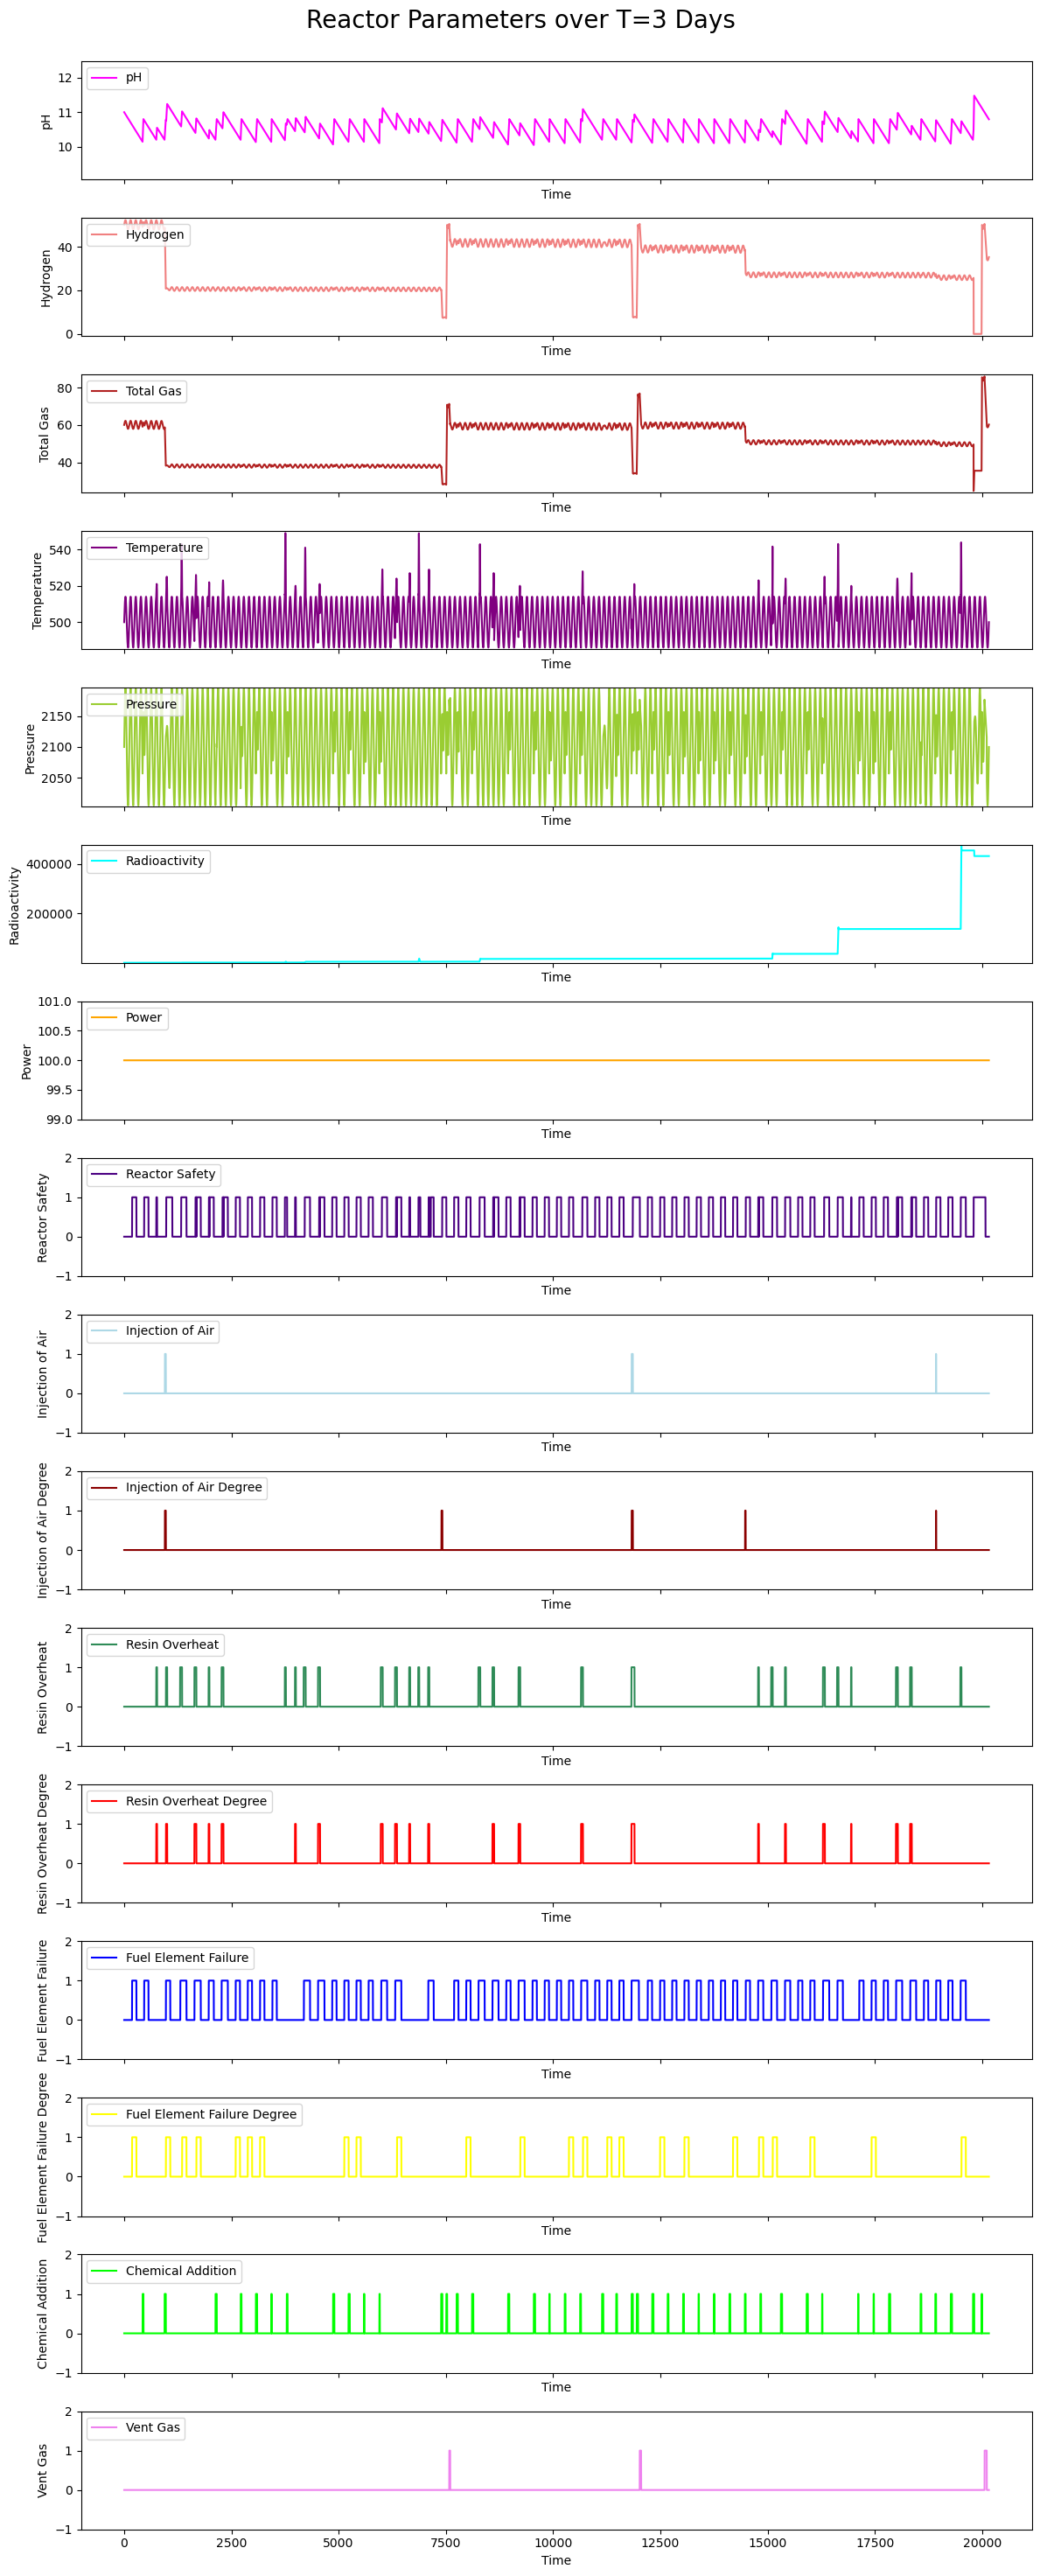

In [7]:
datamT = data.drop(columns=["Time"])
color = ["magenta", "lightcoral", "firebrick", 
         "purple", "yellowgreen", "cyan",
         "orange", "indigo", "lightblue",
         "darkred", "seagreen", "red", "blue", "yellow", 
         "lime", "violet"]
fig, axes = plt.subplots(len(datamT.columns), 1, figsize=(12, 30), sharex=True)
fig.suptitle("Reactor Parameters over T=3 Days", fontsize=20)
for i, feature in enumerate(datamT.columns):
    axes[i].plot(datamT.index, datamT[feature], label=feature, color=color[i])
    axes[i].set_ylabel(feature)
    axes[i].legend(loc='upper left')
    axes[i].set_ylim(datamT[feature].min() - 1, datamT[feature].max() + 1)
    axes[i].set_xlabel("Time")
plt.tight_layout()
plt.subplots_adjust(top=0.96)



## Data Preprocessing and Set Parameters for LSTM

In [8]:
numerical = ['Time', 'pH', 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure','Radioactivity', 'Power']
categorical = ['Reactor Safety', 'Injection of Air', 'Injection of Air Degree', 
               'Resin Overheat', 'Resin Overheat Degree', 'Fuel Element Failure', 
               'Fuel Element Failure Degree', 'Chemical Addition', 'Vent Gas']


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
def preprocess_data(data, npast = 50, n_future = 1440):

    # In case there are NaN values
    data = data.fillna(False)
    data[categorical] = data[categorical].astype(int) # set categorical as integer

    # make sure no NaN values
    unique_values = data.apply(pd.Series.unique)
    # print(unique_values)
    
    # training matrices
    X = np.array(data[numerical].drop(columns=['Time']))
    Y = np.array(data[categorical])

    scalerX, X_norm = utils.scale(X)
    scalerY, Y_norm = utils.scale(Y)

    print(f'Y_norm: {Y_norm.shape}')
    Y_norm = np.array(Y_norm, dtype = int)
    Y_labels = np.argmax(Y_norm, axis = 1)

    print(f'Y_labels: {Y_labels.shape}')

    #Y_norm = Y_norm.reshape(Y_norm.shape[0], -1)
    #print(f'y_shape after resahpe: {Y_norm.shape}')


    # Class balancing using SMOTE
    smote = SMOTE(sampling_strategy = 'auto', k_neighbors = 1, random_state = 42) 
    X_resampled, Y_resampled = smote.fit_resample(X_norm, Y_labels)

    print(f'Y_rersampled: {Y_resampled.shape}')

    encoder = OneHotEncoder(sparse_output=False)
    Y_resampled_onehot = encoder.fit_transform(Y_resampled.reshape(-1, 1))  # Convert to one-hot encoding

    print(f'Y_resampled_ohe: {Y_resampled_onehot.shape}')
    # # Reshape based on timesteps
    [X, _] = utils.prep_lstm_data(X, npast, n_future)
    [_, Y] = utils.prep_lstm_data(Y, npast, n_future)

    # # Rreshape back into irignal format
    # X_resampled = X_resampled.reshape(-1, npast, X.shape[2])  
    # Y_resampled = Y_resampled.reshape(-1, npast, Y.shape[2])  

    return X, Y

In [9]:
# training matrices
npast = 75
n_future = 60
X, Y = preprocess_data(data, npast = npast, n_future = n_future)

Y_norm: (20161, 9)
Y_labels: (20161,)
Y_rersampled: (132111,)
Y_resampled_ohe: (132111, 7)


/home/kxlee/miniconda3/envs/msse-python/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/kxlee/miniconda3/envs/msse-python/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [10]:
X.shape

(20027, 75, 7)

In [11]:
Y.shape

(20027, 60, 9)

### Train Test Split

In [12]:
cut = int(np.round(0.7*Y.shape[0]))

TrainX, TrainY = X[:cut], Y[:cut]
TestX, TestY = X[cut:], Y[cut:]


In [13]:
TestX.shape

(6008, 75, 7)

## Train Model

In [14]:
# # if using covultional layer
# TrainX = TrainX.reshape((TrainX.shape[0], 1, TrainX.shape[1], TrainX.shape[2]))

In [15]:
my_model = lstm(neurons= [32],
                activation_func = 'tanh',
                nTimesteps= npast,
                nFeatures = 7,
                npredTimesteps = n_future,
                npredFeatures = 9,
                model_optimizer = 'adam',
                model_loss = 'binary_crossentropy',
                model_metrics = ['accuracy'],
                dropout = 0.3,
                conv_layer = False,
                nfilters = 64,
                cact = 'relu',
                cpool = 2,
                classify = True)


2024-12-12 17:08:09.565610: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:

from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# fit and Train model

num_epochs = 10
batches = 32


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = my_model.fit(TrainX, TrainY, nEpochs = num_epochs, nBatches=  batches, val_split = 0.2, verb = 2, shuf = False, callbacks = [early_stopping])

Epoch 1/10
351/351 - 9s - 26ms/step - accuracy: 0.3893 - loss: 0.4944 - val_accuracy: 0.4030 - val_loss: 0.3484
Epoch 2/10
351/351 - 8s - 22ms/step - accuracy: 0.4426 - loss: 0.3210 - val_accuracy: 0.2788 - val_loss: 0.2887
Epoch 3/10
351/351 - 9s - 25ms/step - accuracy: 0.4404 - loss: 0.2830 - val_accuracy: 0.1730 - val_loss: 0.2731
Epoch 4/10
351/351 - 8s - 23ms/step - accuracy: 0.4625 - loss: 0.2724 - val_accuracy: 0.2809 - val_loss: 0.2634
Epoch 5/10
351/351 - 8s - 24ms/step - accuracy: 0.4518 - loss: 0.2679 - val_accuracy: 0.0857 - val_loss: 0.2625
Epoch 6/10
351/351 - 10s - 29ms/step - accuracy: 0.4496 - loss: 0.2667 - val_accuracy: 0.0546 - val_loss: 0.2623
Epoch 7/10
351/351 - 9s - 26ms/step - accuracy: 0.4453 - loss: 0.2658 - val_accuracy: 0.0098 - val_loss: 0.2623
Epoch 8/10
351/351 - 9s - 25ms/step - accuracy: 0.4369 - loss: 0.2643 - val_accuracy: 0.0109 - val_loss: 0.2626
Epoch 9/10
351/351 - 10s - 30ms/step - accuracy: 0.4387 - loss: 0.2638 - val_accuracy: 0.0180 - val_los

In [20]:
out = my_model.get_model().history

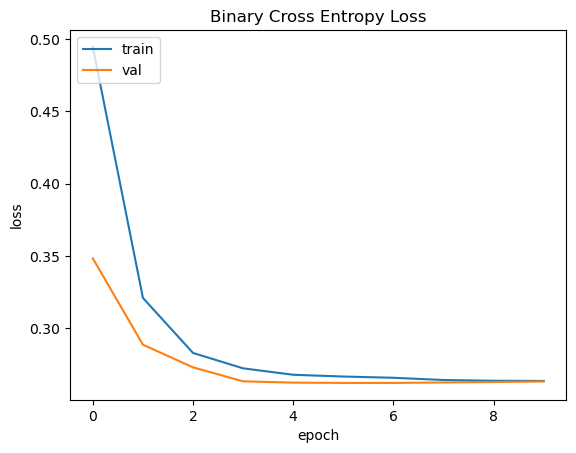

In [21]:
# plotting loss during training
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Binary Cross Entropy Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()


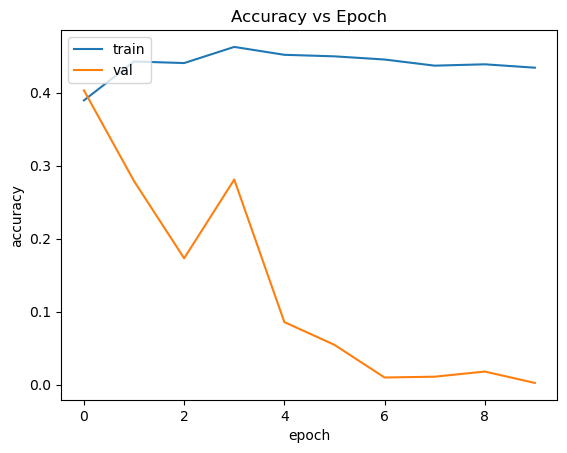

In [22]:
# plotting accuracy during training
plt.plot(out.history['accuracy'])
plt.plot(out.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

## Define helper functions for graphing

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def generate_cm(y_true, y_pred, title = 'Confusion Matrix'):
    """Generates Confusion Matrix Combining all Classes"""

    # Flatten the multilabel arrays into a binary array
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Generate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['False', 'True'], 
                yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{title}")
    plt.show()



In [24]:
from sklearn.metrics import multilabel_confusion_matrix
def generate_cm_multi_label(y_true, y_pred, labels, title = 'Confusion Matrix'):

    cm = multilabel_confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix for each label
    for i, cm_label in enumerate(cm):
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm_label, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['False', 'True'], 
                    yticklabels=['False', 'True'])
        plt.title(f"{title} for Label {labels[i]}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


In [25]:
from sklearn.metrics import roc_curve, auc
def generate_roc(y_true, y_pred_proba, labels, title = 'ROC'):
    """y_pred_proba is the probabilites"""
    for i, label in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred_proba[:,i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label = f'ROC curve(AUC = {roc_auc:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {label}')
        plt.legend(loc='lower right')
        plt.show()


## Evalute on Training Data

In [26]:
train_pred = my_model.predict(TrainX)

439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [27]:
# ensure output is 1 or 0
threshold = 0.7
train_pred_class = (train_pred >= threshold).astype(int)

# reshape output into 2D
TrainY_2d = TrainY.reshape(-1, TrainY.shape[2])  
train_pred_2d = train_pred_class.reshape(-1, train_pred_class.shape[2])  

In [28]:
from sklearn.metrics import accuracy_score, f1_score

print(f'Accuracy Train: {accuracy_score(TrainY_2d, train_pred_2d)}')
# print(f'F1 Train: {f1_score(TrainY_2d, train_pred_2d, average = 'weighted')}')

Accuracy Train: 0.5919704210951804


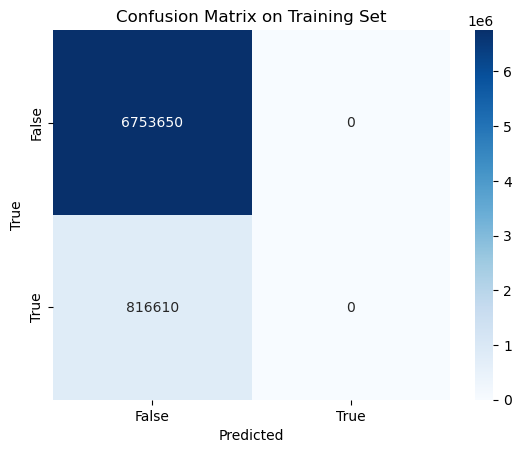

In [29]:
# confusion matrix, combining all classes
generate_cm(TrainY_2d, train_pred_2d, title = 'Confusion Matrix on Training Set')

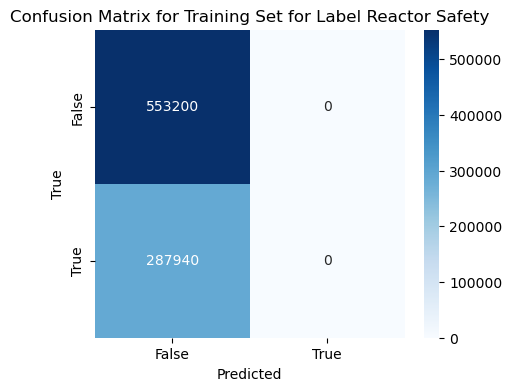

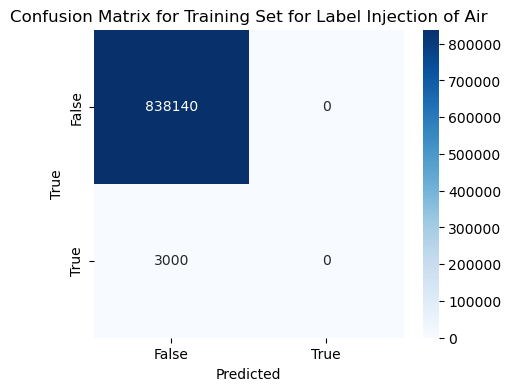

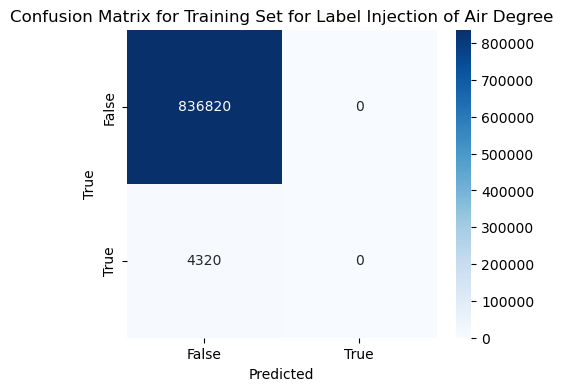

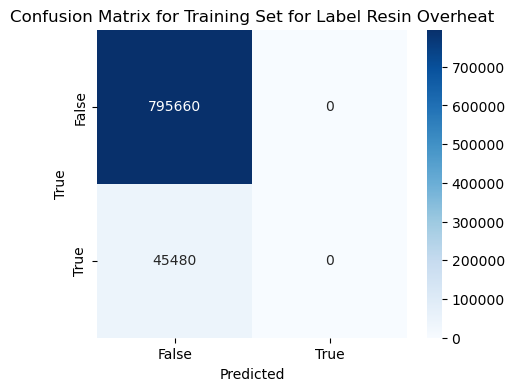

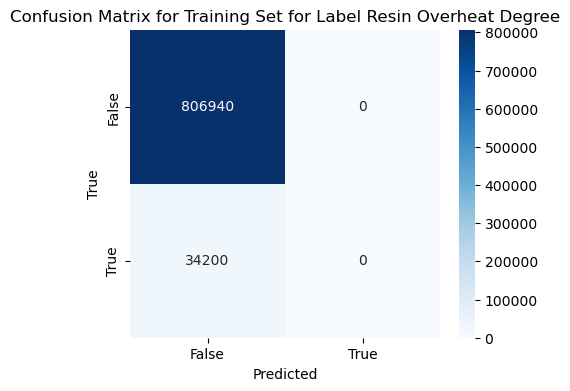

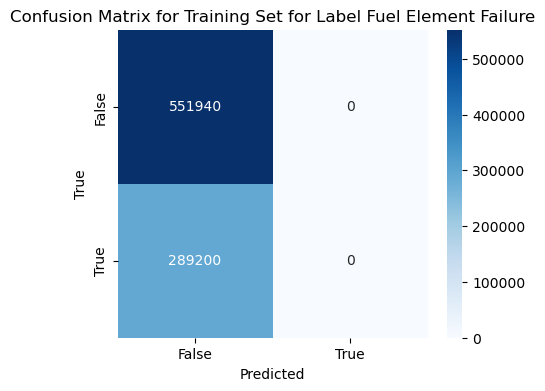

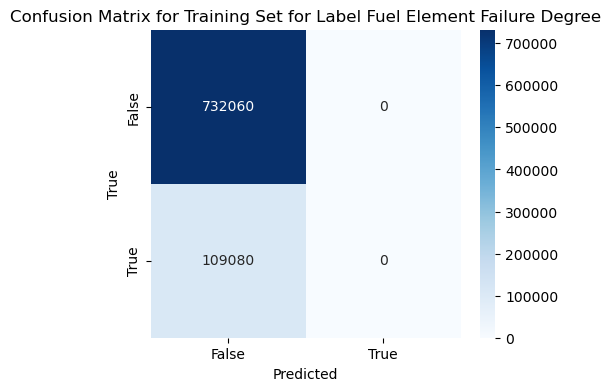

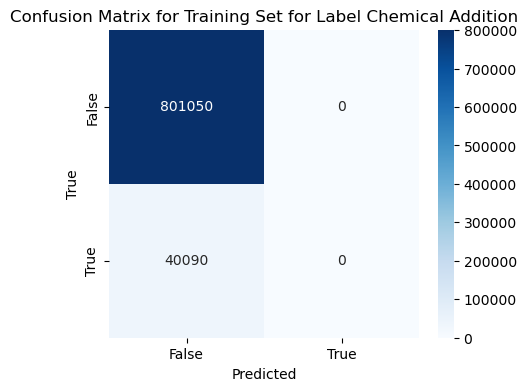

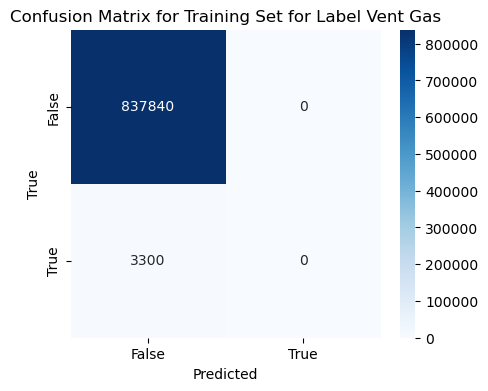

In [76]:
# generate cm for each class
labels = ['Reactor Safety', 'Injection of Air', 'Injection of Air Degree', 
          'Resin Overheat', 'Resin Overheat Degree', 'Fuel Element Failure', 
          'Fuel Element Failure Degree', 'Chemical Addition', 'Vent Gas']

generate_cm_multi_label(TrainY_2d, train_pred_2d, labels, title = 'Confusion Matrix for Training Set')

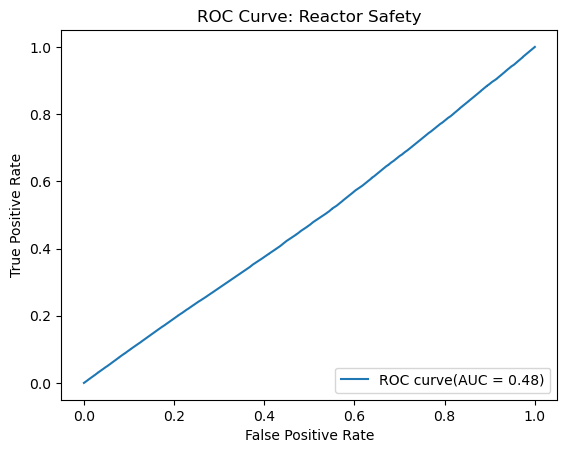

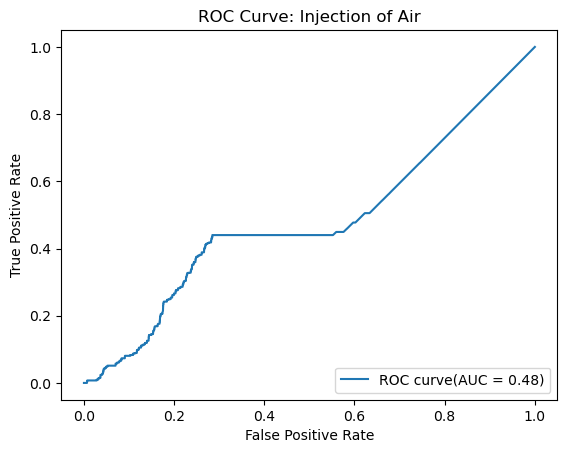

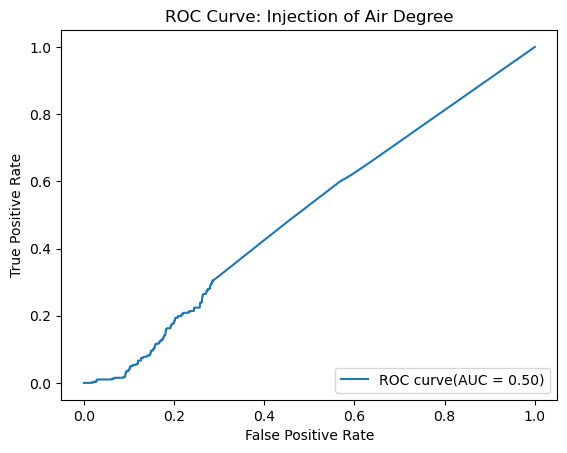

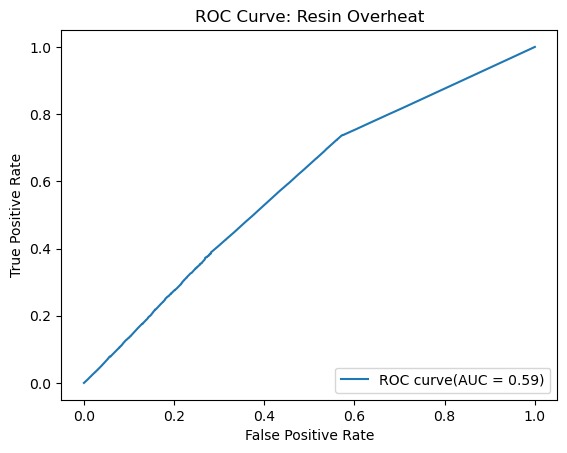

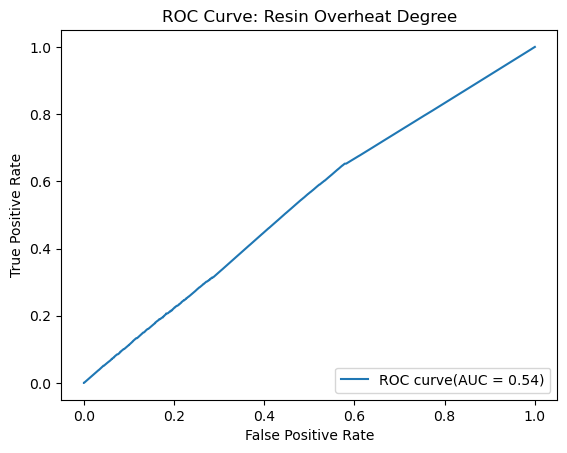

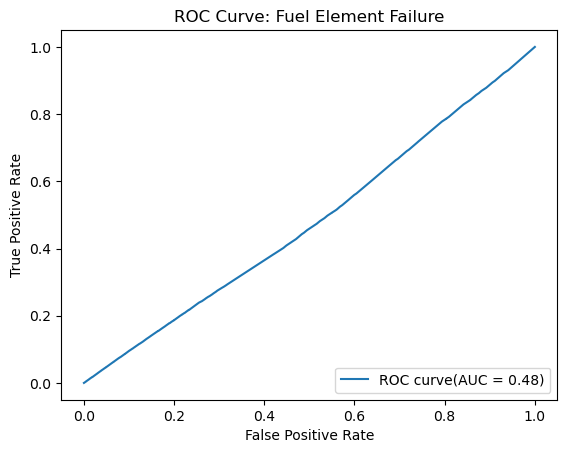

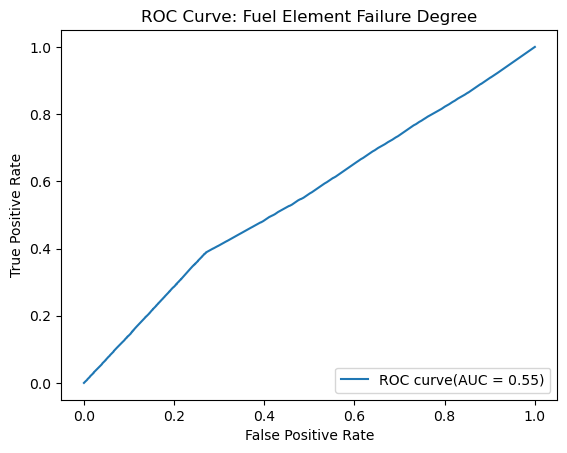

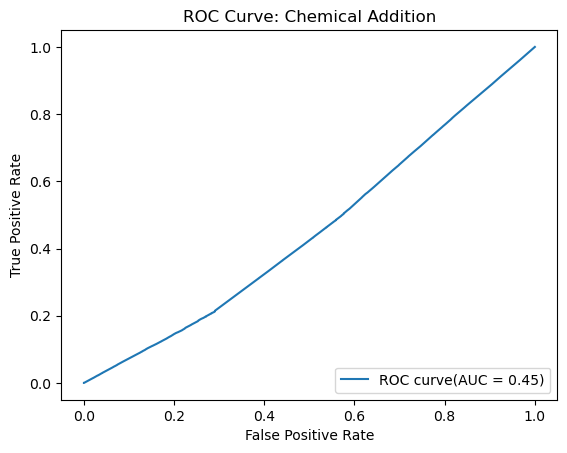

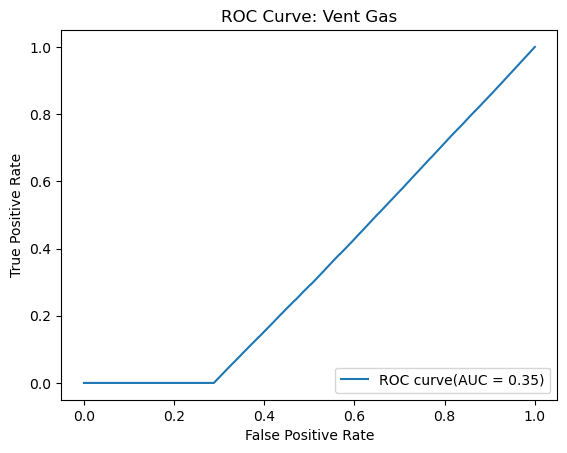

In [48]:

train_prob_2d = train_pred.reshape(-1, train_pred.shape[2])  

# train_proba_2d must be probabilites
generate_roc(TrainY_2d, train_prob_2d, labels, title = 'ROC')

## Evaluate on Validation Set

In [49]:
TestX.shape

(6008, 75, 7)

In [50]:
# # if using covultional layer
# TestX = TestX.reshape((TestX.shape[0], 1, TestX.shape[1], TestX.shape[2]))

In [51]:
test_pred = my_model.predict(TestX)

  1/188 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step


In [52]:
# ensure output is 1 or 0
test_pred_class = (test_pred >= threshold).astype(int)

# reshape output into 2D
TestY_2d = TestY.reshape(-1, TestY.shape[2])  
test_pred_2d = test_pred_class.reshape(-1, test_pred_class.shape[2])  

In [53]:
from sklearn.metrics import accuracy_score, f1_score

print(f'Accuracy Test: {accuracy_score(TestY_2d, test_pred_2d)}')
# print(f'F1 Test: {f1_score(TestY_2d, test_pred_2d)}')

Accuracy Test: 0.5668719485130936


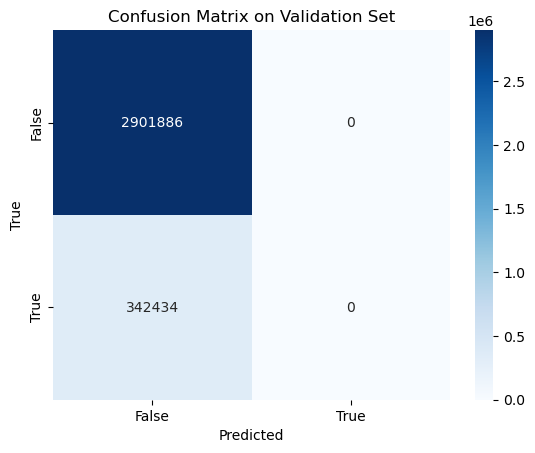

In [54]:
# confusion matrix
generate_cm(TestY_2d, test_pred_2d, title = 'Confusion Matrix on Validation Set')

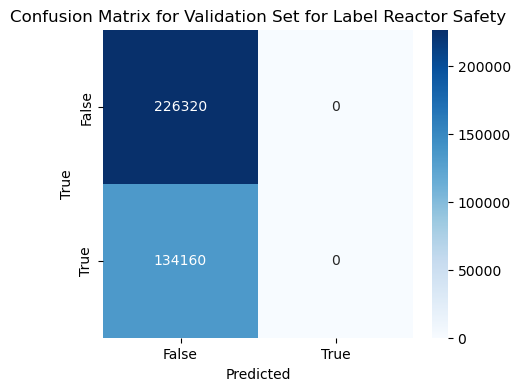

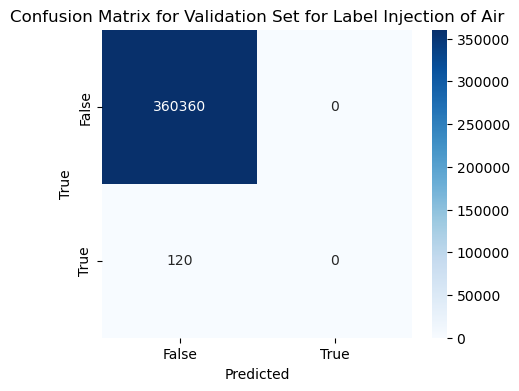

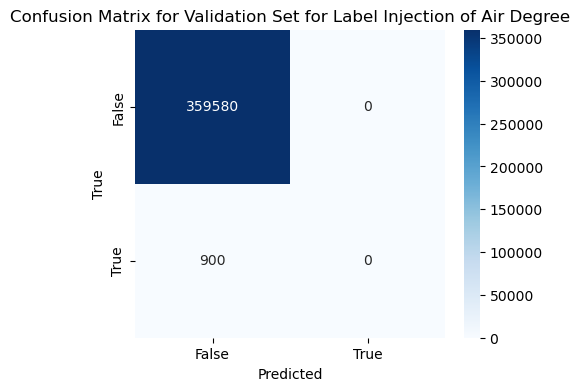

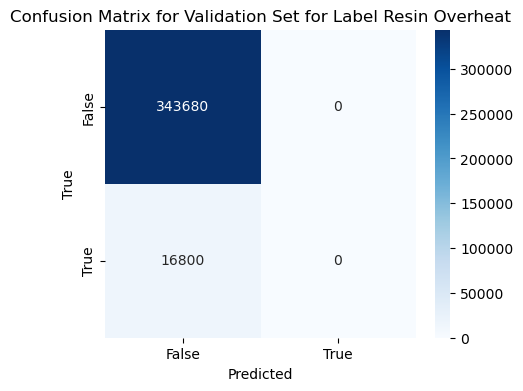

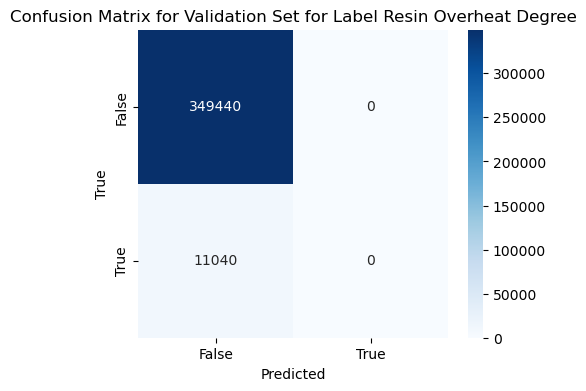

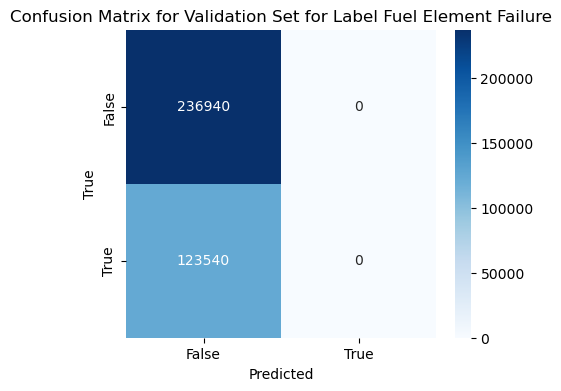

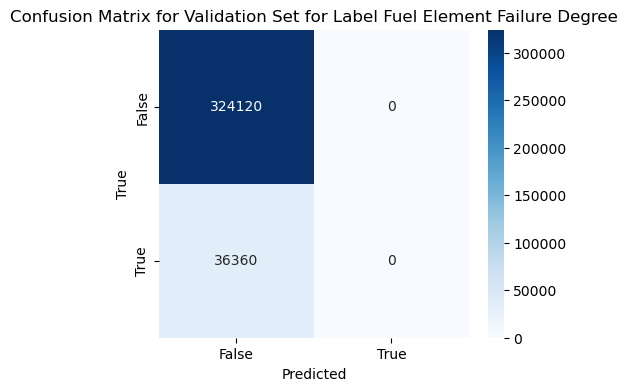

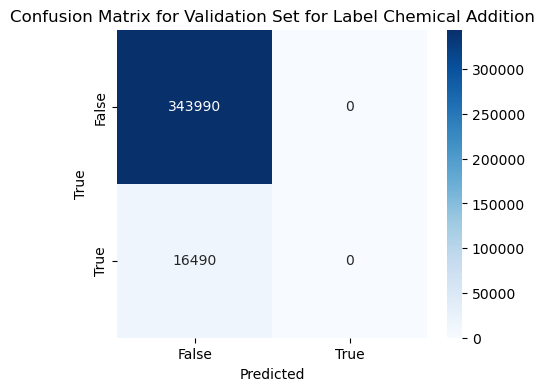

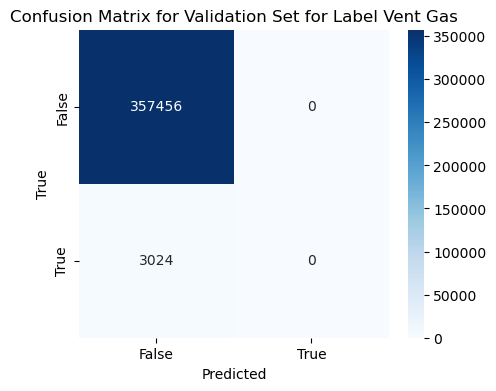

In [55]:
generate_cm_multi_label(TestY_2d, test_pred_2d, labels, title = 'Confusion Matrix for Validation Set')

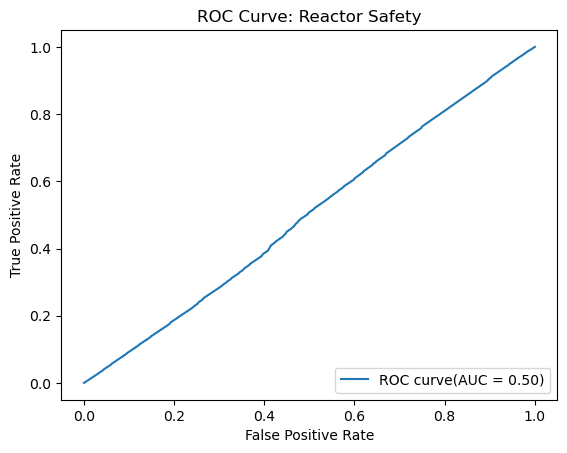

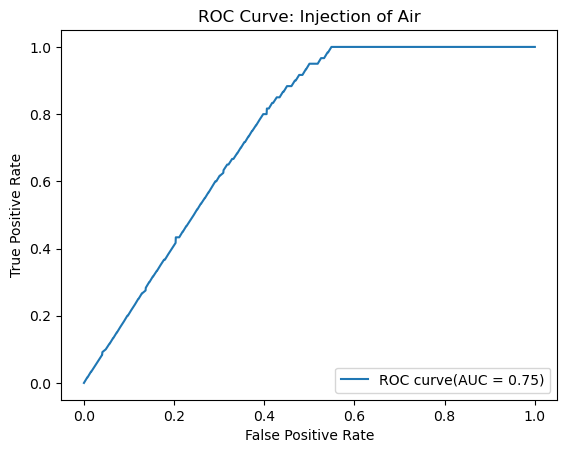

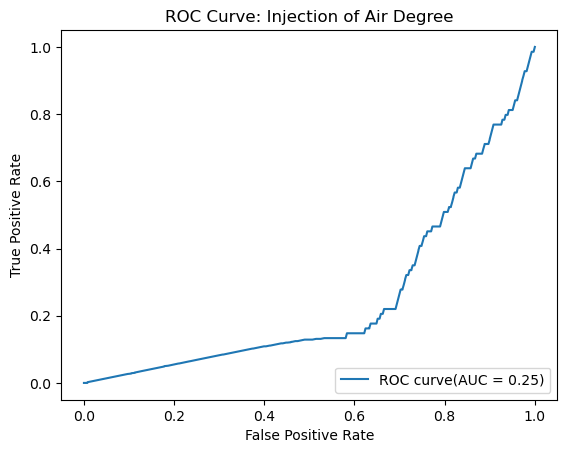

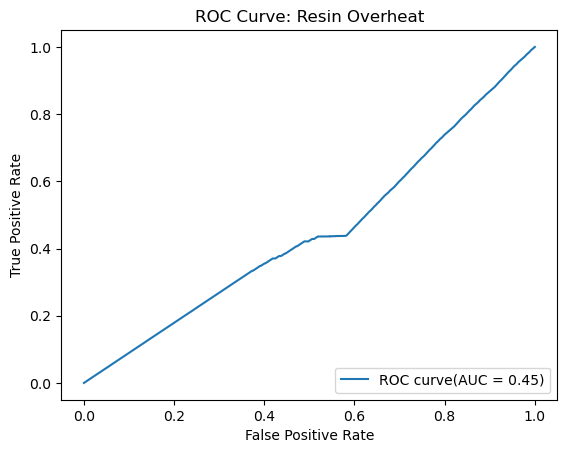

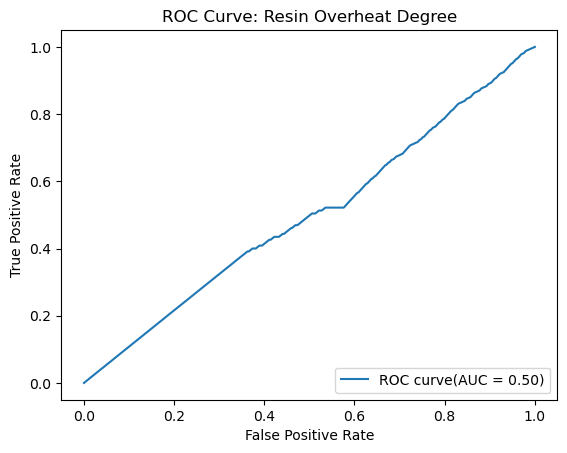

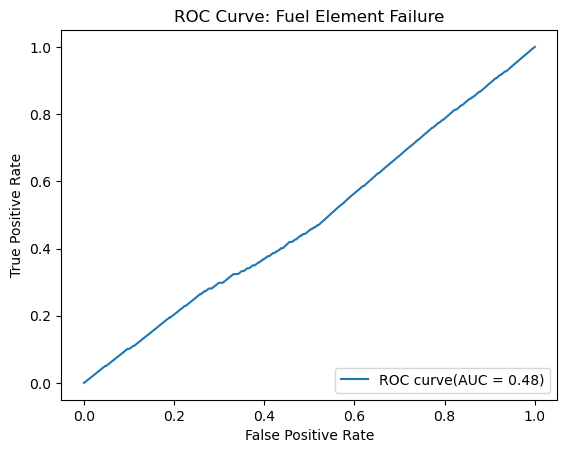

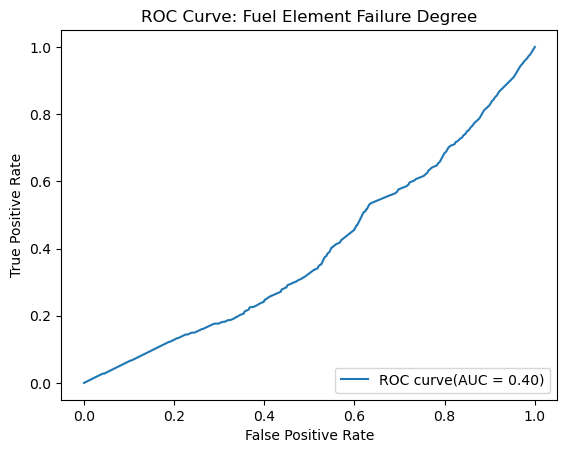

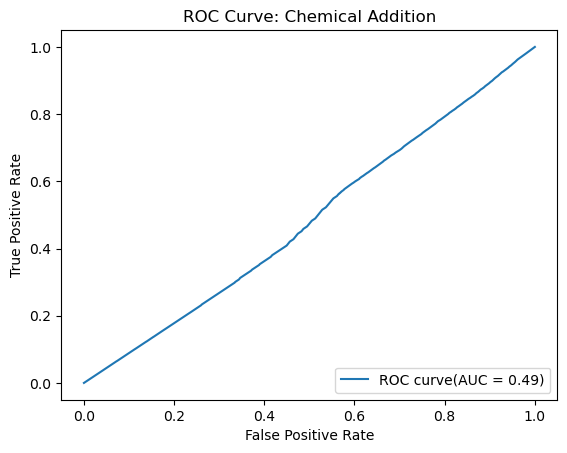

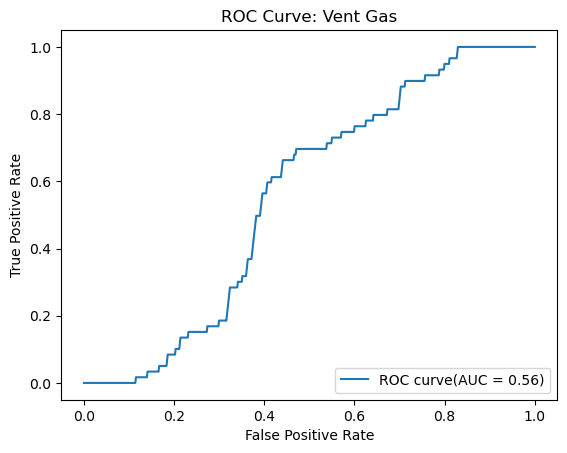

In [56]:

test_prob_2d = test_pred.reshape(-1, test_pred.shape[2])  
generate_roc(TestY_2d, test_prob_2d, labels, title = 'ROC')

## Test Model on Each Casualty

In [57]:
numerical = ['Time', 'pH', 'Hydrogen', 'Total Gas', 'Temperature', 'Pressure','Radioactivity', 'Power']
categorical = ['Reactor Safety', 'Injection of Air', 'Injection of Air Degree', 
               'Resin Overheat', 'Resin Overheat Degree', 'Fuel Element Failure', 
               'Fuel Element Failure Degree', 'Chemical Addition', 'Vent Gas']


def preprocess_data(data, n_past = 50, n_future = 1440):
    # In case there are NaN values
    data = data.fillna(False)
    data[categorical] = data[categorical].astype(int) # set categorical as integer

    # make sure no NaN values
    unique_values = data.apply(pd.Series.unique)
    # print(unique_values)
    
    # training matrices
    X = np.array(data[numerical].drop(columns=['Time']))
    Y = np.array(data[categorical])

    scalerX, X_norm = utils.scale(X)
    scalerY, Y_norm = utils.scale(Y)
    # print(f'x_shape scaled: {X_norm.shape}')
    # print(f'y_shape scaled: {Y_norm.shape}')

    # Reshape based on timesteps
    [X, _] = utils.prep_lstm_data(X_norm, npast, n_future)
    [_, Y] = utils.prep_lstm_data(Y_norm, npast, n_future)


    return X, Y